In [1]:
import json
import torch
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from s4hci.utils.data_handling import load_adi_data, save_as_fits
from s4hci.models.psf_subtraction import S4
from s4hci.models.noise import S4Noise
from s4hci.utils.logging import print_message, setup_logger

# Files we need

In [2]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_304_199_C-0065_C_.hdf5"
reg_lambda = 1934

saved_model_raw = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_304_199_C-0065_C_/results/0000/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_304_199_C-0065_C_/results/0000/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/03_contrast_grid/study_fine_tuning/"

In [27]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_303_199_C-0065_C_.hdf5"
reg_lambda = 1517

saved_model_raw = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_303_199_C-0065_C_/results/0000/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_303_199_C-0065_C_/results/0000/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/03_contrast_grid/study_fine_tuning/"

In [48]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_310_0100_C-0656_A_.hdf5"
reg_lambda = 2274

saved_model_raw = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_310_0100_C-0656_A_/results/0000/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_310_0100_C-0656_A_/results/0000/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/03_contrast_grid/study_fine_tuning/"

In [63]:
# 1.) Load the arguments
dataset_hdf5_file = "/fast/mbonse/s4/30_data/HD22049_351_096_C-0679_A_.hdf5"
reg_lambda = 793

saved_model_raw = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_351_096_C-0679_A_/results/0000/models/noise_model_closed_form.pkl"
saved_model_fine_tuned = "/fast/mbonse/s4/70_results/03_contrast_grid/finished/"\
    "HD22049_351_096_C-0679_A_/results/0000/models/noise_model_fine_tuned.pkl"

work_dir = "/fast/mbonse/s4/70_results/03_contrast_grid/study_fine_tuning/"

In [64]:
loaded = torch.load(saved_model_fine_tuned)
loaded["normalization"] = "normal"
torch.save(loaded, saved_model_fine_tuned)

loaded = torch.load(saved_model_raw)
loaded["normalization"] = "normal"
torch.save(loaded, saved_model_raw)

# Load the data

In [3]:
science_data, raw_angles, raw_psf_template_data = \
    load_adi_data(
        hdf5_dataset=dataset_hdf5_file,
        data_tag="object",
        psf_template_tag="psf_template",
        para_tag="header_object/PARANG")

science_data = science_data[:, 12:-12, 12:-12]

# Background subtraction of the PSF template
psf_template_data = np.median(raw_psf_template_data, axis=0)
psf_template_data = psf_template_data - np.min(psf_template_data)

# Restore the two models

In [4]:
s4_model_raw = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [5]:
s4_noise_raw = S4Noise.load(saved_model_raw)
s4_model_raw.noise_model = s4_noise_raw.float()

Creating right reason mask ... [DONE]


In [6]:
s4_model_fine_tuned = S4(
    data_cube=science_data,
    parang=raw_angles,
    psf_template=psf_template_data,
    noise_noise_cut_radius_psf=4.0,
    noise_mask_radius=5.5,
    device=0,
    noise_lambda_init=reg_lambda,
    noise_normalization="normal",
    planet_convolve_second=True,
    planet_use_up_sample=1,
    work_dir=work_dir,
    verbose=True)

Creating right reason mask ... [DONE]


In [7]:
s4_noise_fine_tuned = S4Noise.load(saved_model_fine_tuned)
s4_model_fine_tuned.noise_model = s4_noise_fine_tuned.float()

Creating right reason mask ... [DONE]


# Compute the loss terms

In [8]:
def compute_noise_estimate(model_in):
    # get all the data
    x_train = torch.from_numpy(model_in.data_cube).float()
    x_mu = torch.mean(x_train, axis=0)
    x_std = torch.std(x_train, axis=0)
    x_norm = (x_train - x_mu) / x_std
    
    # run the forward pass
    science_norm_flatten = x_norm.view(x_norm.shape[0], -1)
    model_in.noise_model.compute_betas()
    noise_estimate = model_in.noise_model(science_norm_flatten)
    
    return x_norm.view(-1, 117, 117).detach().numpy(), noise_estimate.view(-1, 117, 117).detach().numpy()

In [9]:
data_raw, noise_raw = compute_noise_estimate(s4_model_raw)
data_fine_tuned, noise_fine_tuned = compute_noise_estimate(s4_model_fine_tuned)

## The loss terms

In [10]:
np.sum((data_raw - noise_raw)**2)

376152500.0

In [11]:
np.sum((data_fine_tuned - noise_fine_tuned)**2)

376113500.0

In [12]:
np.sum((s4_model_raw.noise_model.betas_raw **2).detach().numpy())

8281.342

In [13]:
np.sum((s4_model_fine_tuned.noise_model.betas_raw **2).detach().numpy())

8276.607

In [14]:
errors_raw = np.mean((data_raw - noise_raw)**2, axis=(1, 2))
errors_fine_tuned = np.mean((data_raw - noise_fine_tuned)**2, axis=(1, 2))

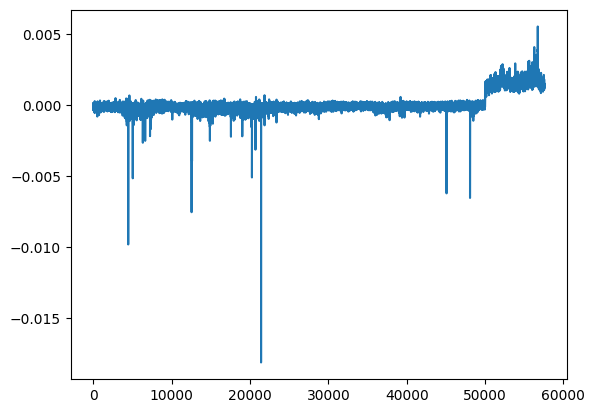

In [15]:
plt.plot(errors_raw - errors_fine_tuned)

## plot some frames

In [16]:
idx = 100

test_noise_estimate_raw = noise_raw[idx]
test_noise_estimate_ft = noise_fine_tuned[idx]
test_raw_data = data_raw[idx]

test_residual_raw = test_raw_data - test_noise_estimate_raw
test_residual_ft= test_raw_data - test_noise_estimate_ft

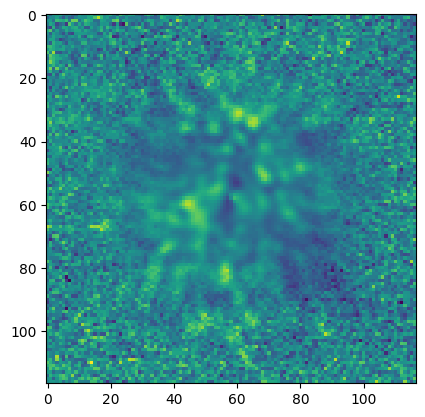

In [17]:
plt.imshow(test_raw_data)

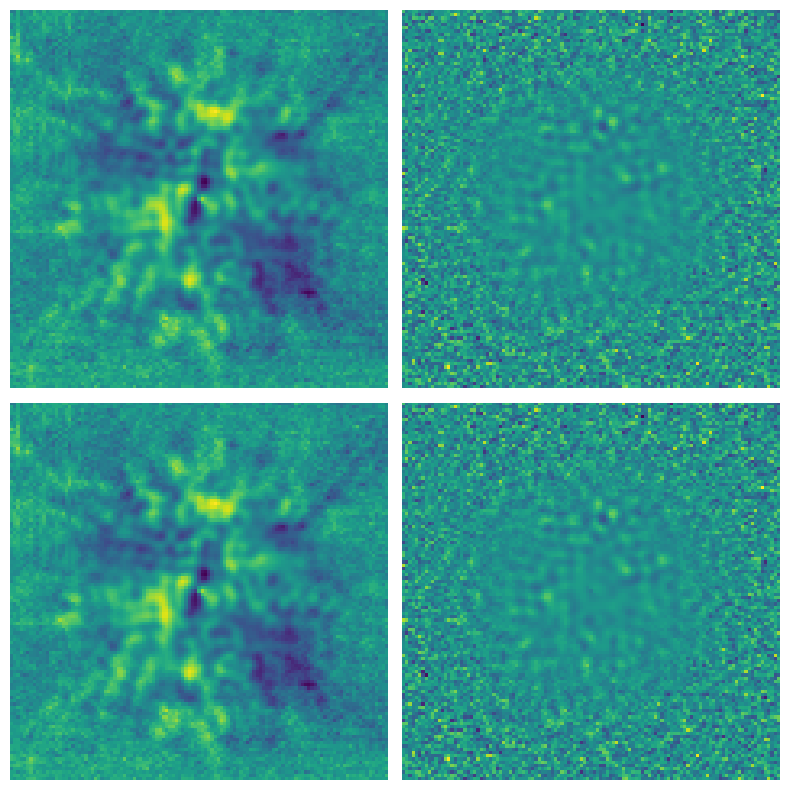

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 8))

ax1.imshow(test_noise_estimate_raw)
ax2.imshow(test_residual_raw)

ax3.imshow(test_noise_estimate_ft)
ax4.imshow(test_residual_ft)

ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")

plt.tight_layout()

# Plot the difference in weights

In [54]:
beta_difference = s4_model_fine_tuned.noise_model.betas - s4_model_raw.noise_model.betas

In [55]:
i=70
j=80
idx=117*i + j

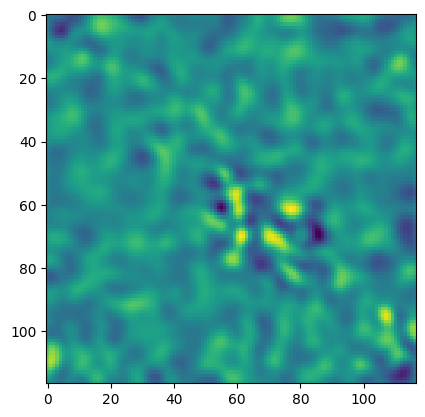

In [56]:
plt.plot(beta_difference[idx].reshape(117, 117).detach().numpy())

In [60]:
most_changed_region = torch.mean(torch.abs(beta_difference), axis=0).reshape(117, 117)

(-0.5, 116.5, 116.5, -0.5)

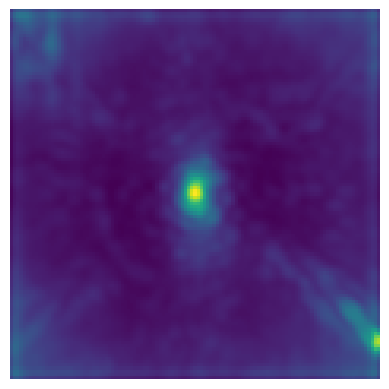

In [62]:
plt.imshow(most_changed_region.detach().numpy())
plt.axis("off")